# Installation of Required Libraries


- `langchain`:

Used for chaining different components together to form an end-to-end workflow. We use langchain for integrating text processing, document loading, retrieval, and generative AI models into one cohesive pipeline.


- `langchain_community`:

Provides community-driven extensions. We use it for loading documents from the web via WebBaseLoader, splitting text into manageable chunks with RecursiveCharacterTextSplitter, and leveraging Chroma for the vector store and retriever functionality.

- `langchainhub`:

Used for pulling pre-built prompts from a shared repository. In this case, it pulls a RAG-related prompt using hub.pull, which is later used in our RAG chain to handle the query input.


- `langchain_google_genai`:

This library integrates Google's Gemini AI model with LangChain, allowing us to use the Gemini-1.5-Flash-Latest model for generating answers to questions based on the retrieved context.


- `gpt4all`:

Provides the GPT4AllEmbeddings model, used for embedding documents and turning them into high-dimensional vectors. These embeddings help in finding the most relevant information when a user asks a query.


- `chromadb`:

Used as the vector database to store the embeddings. We use Chroma from langchain_community for efficiently managing and searching the embedded vectors of our documents. This allows us to retrieve the most relevant chunks of text when processing user queries.

In [1]:
%%capture
!pip install langchain langchain_community langchain_text_splitters langchainhub langchain_google_genai gpt4all chromadb

# Setting up Environment

We'll be using `Gemini` as our chat-based Large Language Model (LLM). To access Gemini, we need to set the API key as an environment variable.

**Where to Get the API Key:**

You can obtain your Gemini API key from the [Google AI Studio](https://aistudio.google.com/).


In [2]:
import os
from google.colab import userdata

## TODO: SET GOOGLE_API_KEY in Secrets
os.environ['googleAPIkey'] = userdata.get('googleAPIkey')

# Setting the Vector Database

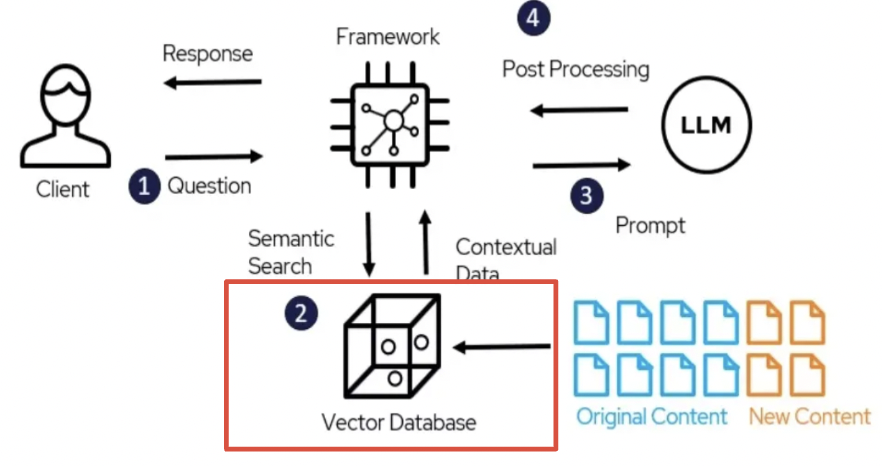

A **Vector Database** is a type of database designed to store and retrieve vectors (numerical representations) of data, such as text, images, and more. These vectors are often generated through machine learning models like embeddings, where data is transformed into high-dimensional space. Each item in the database is represented as a vector in this space.

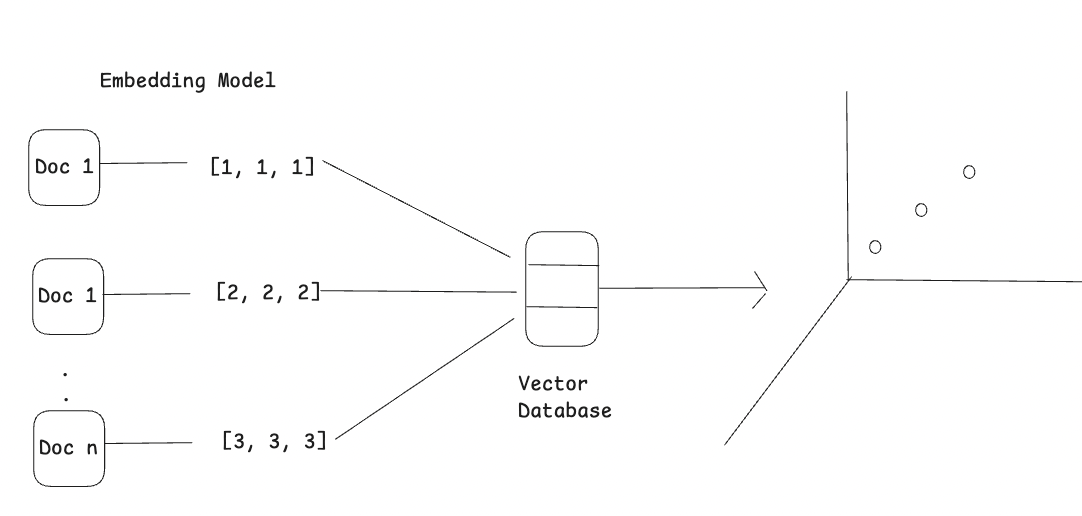

#### Why Do We Need a Vector Database for RAG?

In a **Retrieval-Augmented Generation (RAG)** system, we need to efficiently store and search through large amounts of unstructured data (like documents or text) to retrieve the most relevant context for a given query. Traditional relational databases are not optimized for this task. This is where a vector database comes in:

1. Efficient Search
   
2. Contextual Retrieval

In the context of RAG, we will use the **Chroma** vector database to store the document embeddings and perform similarity-based searches to retrieve relevant context for our generation model (Gemini).



### Loader

[ [Documentation](https://python.langchain.com/docs/integrations/document_loaders/) ]

In [3]:
## TODO: Select a loader based on the requirement
from langchain_community.document_loaders import RecursiveUrlLoader
import bs4
import re

In [4]:
from bs4 import BeautifulSoup
def bs4_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()

In [5]:
## TODO: Initialize the loader
loader =RecursiveUrlLoader('https://semicolon.kingscollege.edu.np/',
                           max_depth=2,
                           extractor= bs4_extractor,
                           )

In [6]:
docs = loader.load()

In [7]:
docs

[Document(metadata={'source': 'https://semicolon.kingscollege.edu.np/', 'content_type': 'text/html; charset=utf-8', 'title': 'Semicolon', 'description': "Join King's student-led hackathon, Semicolon is the ultimate student-led hackathon event, hosted by King’s College, where innovation meets coding. Whether you're a beginner or a seasoned coder, this hackathon is your chance to shine, collaborate, and build cutting-edge solutions.", 'language': 'en'}, page_content='Semicolon'),
 Document(metadata={'source': 'https://semicolon.kingscollege.edu.np/_next/static/media/a34f9d1faa5f3315-s.p.woff2', 'content_type': 'font/woff2'}, page_content='wOF2     ��    �T  �2                       �`��\\�p?HVAR�m?MVAR^`?STAT�N\'& �>/l\n�� ��>� 0��6$� �.�[��qu���yϧ�9���BB���!&/���������>���\n�vP����������&2�z�ئ��e}/�(�C�,�n&�ֈջ�g钴�\r���d�ږ��\\���\\�\t3�L��8B��O~\nu�$��Jm������l���4]�Yr�<�T{\x7ffv�8PJ�] <9%8���Q����<�������̙���&i�&$$�-��M%eB��~��K�&I�e��$I%����秿ܒ��s���{{]Wn�s� �H�dH����$��\r6`0c1j�X� i`` 

### Text Splitter


[ [Documentation](https://python.langchain.com/docs/how_to/recursive_text_splitter/) ]

In [8]:
## TODO: Select a text splitter to split document into multiple chunks

from langchain_text_splitters import RecursiveCharacterTextSplitter

In [9]:
## TODO: Initialize the splitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 100,
    length_function = len,
    is_separator_regex= False,
)

In [10]:
split_docs = text_splitter.split_documents(docs)
len(split_docs)

48

### Embedding

[ [Documentation](https://python.langchain.com/docs/integrations/text_embedding/) ]

In [11]:
from langchain_community.embeddings import GPT4AllEmbeddings

In [12]:
embedding_model = GPT4AllEmbeddings()

Downloading: 100%|██████████| 45.9M/45.9M [00:00<00:00, 82.0MiB/s]
Verifying: 100%|██████████| 45.9M/45.9M [00:00<00:00, 487MiB/s]


In [13]:
a = embedding_model.embed_query("Hello world")
len(a)

384

### Vector Store : Chroma

[ [Documentation](https://python.langchain.com/docs/integrations/vectorstores/) ]

In [14]:
from langchain_community.vectorstores import Chroma

In [15]:
vectorstore = Chroma(embedding_function=embedding_model)

<ipython-input-15-bec1c7c3990f>:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=embedding_model)


In [16]:
vectorstore.add_documents(split_docs)

['718abd06-6758-422c-a4ac-00216f855f0d',
 '255df6cf-256c-42d7-9d38-07a492dcedd5',
 '619fe667-ed0b-4d14-9999-c3de7a4463c6',
 'ded59361-6a3c-42f9-a02d-8073ffb10b5b',
 '24c248e0-80ff-4463-9979-0d5aa50ac0bf',
 '1f015d3e-d17a-441b-a132-c945a1274773',
 '8627250f-1d4c-44ec-a02e-ff56af222daf',
 'c2baff49-35b5-4e97-b809-59e3fa0e1716',
 'e0a7827a-dbfe-41bb-af6c-28f457fec2ed',
 '5fc14c3c-a9fa-432a-beee-fffac979abe0',
 'a2638c1a-6931-4109-a965-7f1d5837070f',
 '35219e1b-c736-4607-af70-2fa960917103',
 'add3deb1-5535-4b7d-9f3d-3a7159c7f525',
 '310dc657-1e70-42a6-8137-c64a8aa95cff',
 '3cca5ef3-790a-43e5-bfbe-415a8a5acd4d',
 '8542da18-1c1c-4902-95d7-5482ff96272e',
 'ff9fe66c-1b3e-4676-a49c-d7b3cd71c350',
 'c28ba038-e908-4798-b0d6-550897ba27bf',
 '6e211a97-74bc-4463-9aac-1d38bbf2312f',
 '99020326-be4f-4e1e-b98c-05f23cec3870',
 '4e89d22f-8eb1-41b3-99b3-25f3e2a1f773',
 '26b0552f-5389-47fc-b4ab-c3933a96b573',
 '0b60d86a-0374-4d66-baa9-ddd5a1294fd0',
 '6ef4cb5c-c82b-4236-b00d-6ed1d86cfc18',
 'ac26c1db-2185-

# Retriever
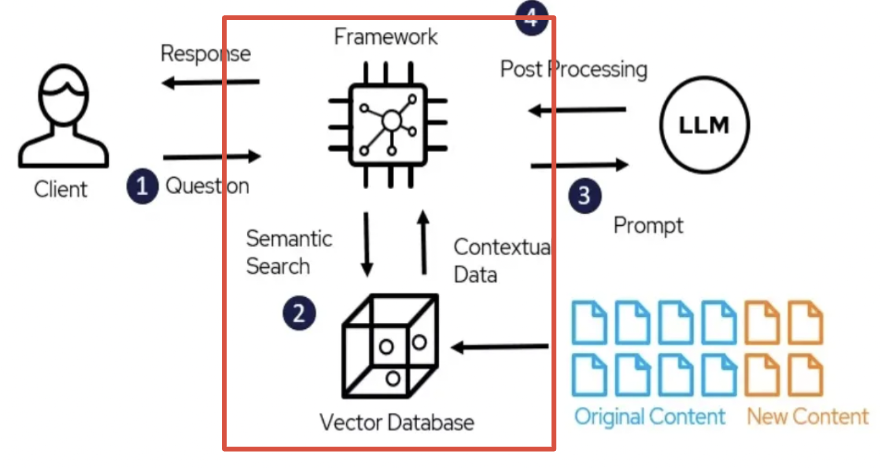

 - A retriever fetches the most relevant information from a knowledge base or external data source based on the query.
- Bridges the gap between the user query and the knowledge base by focusing on relevance.

#### How Does It Work?
- Step 1: Embed the Query
- Step 2: Search the Vector Database
- Step 3: Retrieve Top Results
- Step 4: Provide Context to Generator


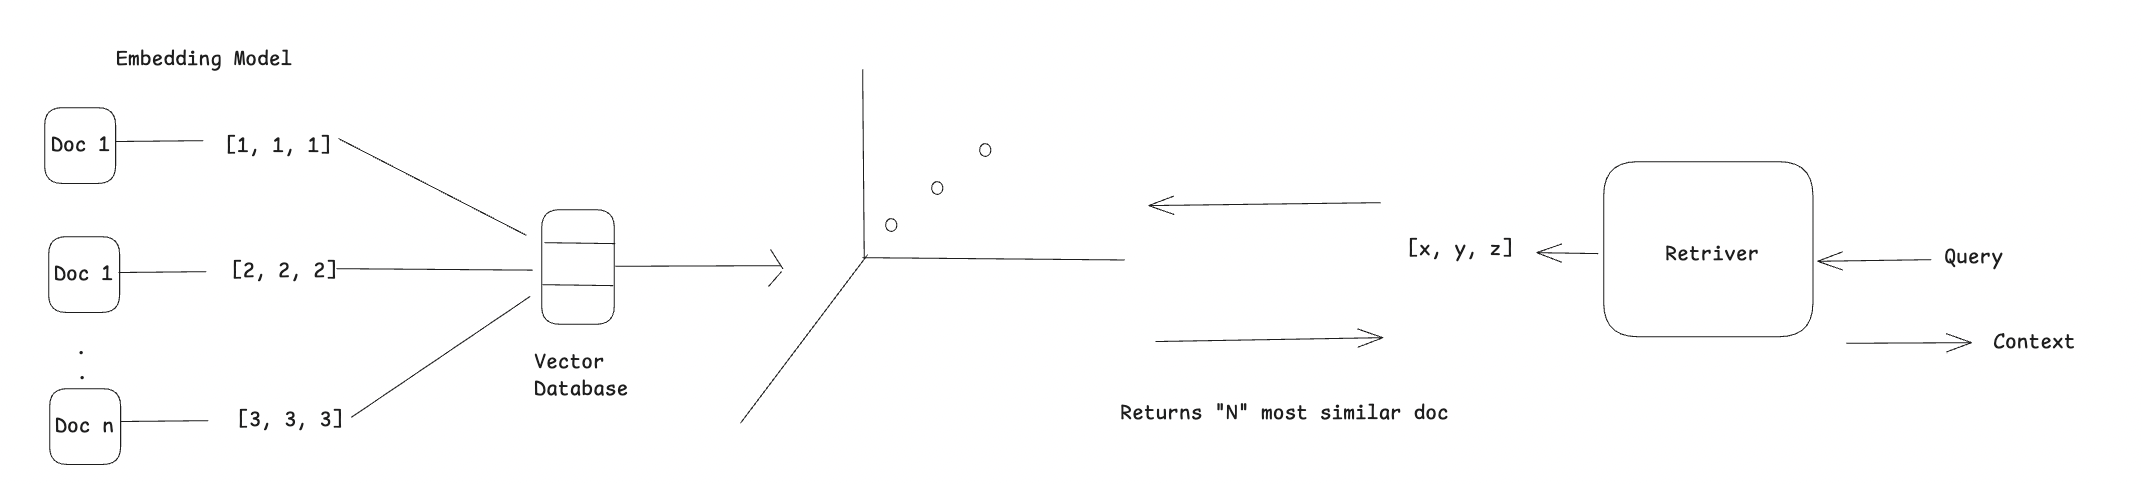

[ [Documentation](https://python.langchain.com/docs/integrations/retrievers/) ]

In [17]:
retriever = vectorstore.as_retriever()

# Generator
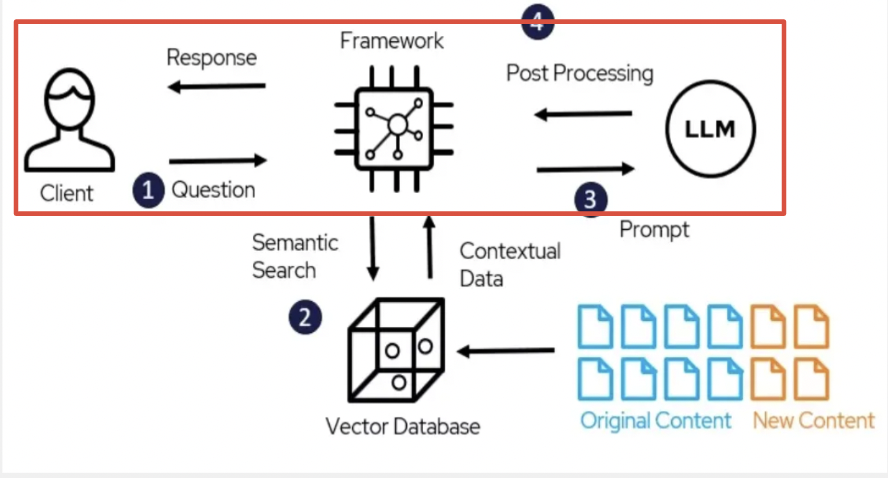


- Powered by LLMs like Gemini to generate human-like, contextual responses.
- Takes the query and the retrieved context as inputs.
- Outputs coherent and relevant answers based on the provided information.

#### How Does It Work?
-  Step 1: Input Query
-  Step 2: Receive Retrieved Context
-  Step 3: Combine Query and Context
-  Step 4: Generate Response


In [18]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI


In [19]:
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [20]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [21]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

In [22]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [23]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [25]:
## TODO: Write a question relevant to your document
question = "Semicolon hackathon 2025"

In [26]:
response = rag_chain.invoke(question)

Streaming output truncated to the last 5000 lines.

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/grpc/_plugin_wrapping.py", line 105, in __call__
    self._metadata_plugin(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/transport/grpc.py", line 95, in __call__
    callback(self._get_authorization_headers(context), None)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/transport/grpc.py", line 81, in _get_authorization_headers
    self._credentials.before_request(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/credentials.py", line 228, in before_request
    self._blocking_refresh(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/credentials.py", line 191, in _blocking_refresh
    self.refresh(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 134, in refresh
    raise new_exc from caught_exc
google.auth.exceptions.RefreshError: ("Failed to

KeyboardInterrupt: 

In [ ]:
print(f"The answer of \"{question}\": \n {response}")